### Training loop stuff


In [ ]:
# | default_exp training
# | hide
import nbdev; nbdev.nbdev_export()
from nbdev.showdoc import *

In [ ]:
# | export
from tidygrad.tensor import Tensor
from tidygrad.utils import noop
import numpy as np

In [ ]:
# | export
def add_callbacks(func):
    # print("Adding callbacks", func.__name__)

    def decorator(self):
        full_name = func.__name__.replace("do_", "")
        pre_name = f"pre_{full_name}"
        post_name = f"post_{full_name}"
        for callback in self.callbacks:
            getattr(callback, pre_name, noop)(self)

        func(self)
        for callback in self.callbacks:
            getattr(callback, post_name, noop)(self)

    return decorator

In [ ]:
# | export

class DictLoggerCallback:
    val_loss = 0
    val_error = 0

    def __init__(self, metrics=None):
        self.metrics = [] if metrics is None else metrics

    def log(self, learner, metric, value, accum=False, step: int = None):
        if not hasattr(learner, "metrics"): learner.metrics = self.metrics
        if step is None:
            step = self.metrics[-1]["step"] + 1 if self.metrics else 0

        if not self.metrics or step != self.metrics[-1]["step"]:
            self.metrics.append({"step": step})

        if metric in self.metrics[-1] and accum:
            self.metrics[-1][metric] += value
        else:
            self.metrics[-1][metric] = value

    def post_calc_loss(self, learner):
        if learner.training:
            self.log(learner, "loss", float(learner.loss.data), step=learner.step)
            self.log(learner, "error", 1 - float((learner.preds.data.argmax(1) == learner.batch[1].data).mean()), step=learner.step)
        else:
            self.val_loss += float(learner.loss.data)
            self.val_error += 1 - float((learner.preds.data.argmax(1) == learner.batch[1].data).mean())
            # self.log("val_loss", float(learner.loss.data), accum=True, step=learner.step)

    def post_epoch(self, learner):
        # val_loss = self.metrics[-1]["val_loss"] / len(learner.dl)
        self.log(learner, "val_loss", self.val_loss / len(learner.dl), step=learner.step)
        self.log(learner, "val_error", self.val_error / len(learner.dl), step=learner.step)
        # self.log("epoch", learner.epoch, step=learner.step)
        self.val_loss = 0
        self.val_error = 0

In [ ]:
# | export

class Learner:
    # dataloaders - train, test
    # model - function that outputs a tensor that can be fed into a loss function
    # loss_func - function that takes in a tensor and outputs a scalar
    # optimizer - Optimizer object
    def __init__(self, dataloaders, model, loss_func, optimizer, callbacks=[]):
        self.dataloaders = dataloaders
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.callbacks = callbacks if callbacks else []

        # The state of the learner. These are updated during training by various do_ functions
        self.training = False  # True if training, False if val/test.
        self.epoch = 0  # current epoch, starts with 1 when you start trainig.
        self.step = 0  # current step, increases by 1 every (training) batch
        self.dl = None  # current dataloader, could be train or test or val
        self.batch = None  # The current batch as a tuple of (x, y)
        self.preds: Tensor = None  # Output of the model

    def fit(self, epochs, start_epoch=0, start_step=None):
        self.start_epoch = start_epoch
        self.n_epochs = epochs
        self.step = self.step if start_step is None else start_step
        self.do_fit()

    @add_callbacks
    def do_fit(self):
        for e in range(self.start_epoch + 1, self.start_epoch + 1 + self.n_epochs):
            self.epoch = e
            self.do_epoch()

    @add_callbacks
    def do_epoch(self):
        self.training = True
        self.dl = self.dataloaders.train
        self.do_all_batches()
        self.dl = self.dataloaders.test
        self.training = False
        self.do_all_batches()

    @add_callbacks
    def do_all_batches(self):
        for batch in self.dl:
            if self.training: self.step += 1
            self.batch = batch
            self.do_batch_forward()
            self.do_calc_loss()
            if self.training: self.do_batch_backward()

    @add_callbacks
    def do_calc_loss(self):
        _, y = self.batch
        self.loss = self.loss_func(self.preds, y)

    @add_callbacks
    def do_batch_forward(self):
        x, _ = self.batch
        self.preds = self.model(x)

    @add_callbacks
    def do_batch_backward(self):
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [ ]:
#| export
from tqdm.auto import tqdm

In [ ]:
#| export
class ProgressBarCallback:
    def __init__(self):
        pass
    
    def pre_all_batches(self, learner):
        if learner.training:
            self.pbar = tqdm(total=len(learner.dl), desc=f"Epoch {learner.epoch}")

    def post_calc_loss(self, learner):
        if learner.training:
            # print(learner.metrics[-1]["loss"])
            self.pbar.update(1)
            self.pbar.set_postfix_str(f"loss={learner.metrics[-1]['loss']:.4f}, error={learner.metrics[-1]['error']:.4f}")

In [ ]:
#| export
def one_hot_encode_batch(y_batch, n_classes):
    batch_size = len(y_batch)
    assert batch_size > 0
    assert n_classes > 0
    assert y_batch.shape == (batch_size, )
    assert np.min(y_batch) >= 0

    # Initialize a zero matrix of shape (batch_size, num_classes)
    one_hot_matrix = np.zeros((batch_size, n_classes))

    # Fill in the appropriate elements
    one_hot_matrix[np.arange(batch_size), y_batch] = 1

    return one_hot_matrix

In [ ]:
from tidygrad.utils.data import DataLoader, DataLoaders
from tidygrad.utils.datasets import MNIST, mnist_batch_tfm
from tidygrad.functional import sigmoid, BCE_loss
from tidygrad.optim import Adam
from functools import partial
from matplotlib import pyplot as plt

In [ ]:
BS=64

mnist_train = DataLoader(MNIST(), batch_size=BS, shuffle=False, batch_tfms=[mnist_batch_tfm])
mnist_test = DataLoader(MNIST(train=False), batch_size=BS, shuffle=False, batch_tfms=[mnist_batch_tfm])

INT_DIM = 128

w1 = Tensor(np.random.randn(784, INT_DIM) * 1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")

w2 = Tensor(np.random.randn(INT_DIM, 10) * 1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")


def linear_model(inputs, params, debug=list()):
    inputs.data = inputs.data.reshape(inputs.data.shape[0], -1)
    x = inputs
    w1, b1, w2 = params
    z1 = sigmoid(x.mmul(w1, "z1") + b1)
    z2 = z1.mmul(w2, "z2")

    return z2


MM_func = partial(linear_model, params=[w1, b1, w2])

optimizer = Adam([w1, b1, w2], lr=0.001)
loss_f = lambda preds, targets: BCE_loss(preds, one_hot_encode_batch(targets.data, 10))

student = Learner(
    dataloaders=DataLoaders(mnist_train, mnist_test),
    model=MM_func,
    loss_func=loss_f,
    optimizer=optimizer,
    callbacks=[DictLoggerCallback(), ProgressBarCallback()],
)

In [ ]:
#| eval: false
student.fit(epochs=5)

Epoch 1:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5:   0%|          | 0/937 [00:00<?, ?it/s]

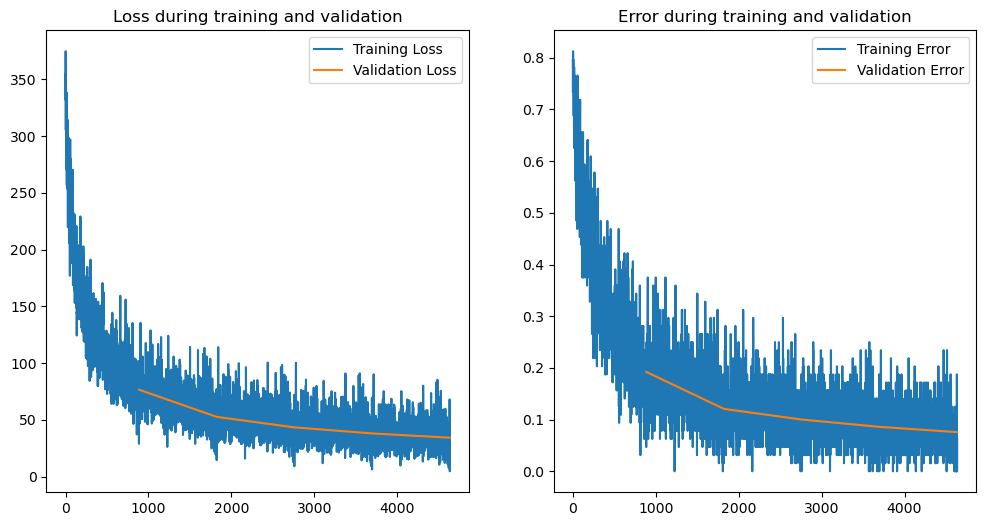

In [ ]:
#| eval: false

losses = []
errors = []
val_losses = []
val_errors = []

for idx, data in enumerate(student.metrics[50:]):
    if 'loss' in data: losses.append((idx, data['loss']))
    if 'error' in data: errors.append((idx, data['error']))
    if 'val_loss' in data: val_losses.append((idx, data['val_loss']))
    if 'val_error' in data: val_errors.append((idx, data['val_error']))

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(*zip(*losses), label='Training Loss')
plt.plot(*zip(*val_losses), label='Validation Loss')
plt.title('Loss during training and validation')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(*zip(*errors), label='Training Error')
plt.plot(*zip(*val_errors), label='Validation Error')
plt.title('Error during training and validation')
plt.legend()

plt.show()